# Cython

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10,6)
%config InlineBackend.figure_format = 'retina'
import numpy as np

In [2]:
import warnings
warnings.filterwarnings("ignore")

![Cython logo](images/440px-Cython-logo.svg.png)

* Cython  provides extra syntax allowing for static type declarations (remember: Python is generally dynamically typed)
* Python code gets translated into optimised C/C++ code and compiled as Python extension modules
* Cython allows you to write fast C code in a Python-like syntax. 
* Furthermore, linking to existing C libraries is simplified.

- Pure Python Function


$f(x)=-2x^3+5x^2+x$,

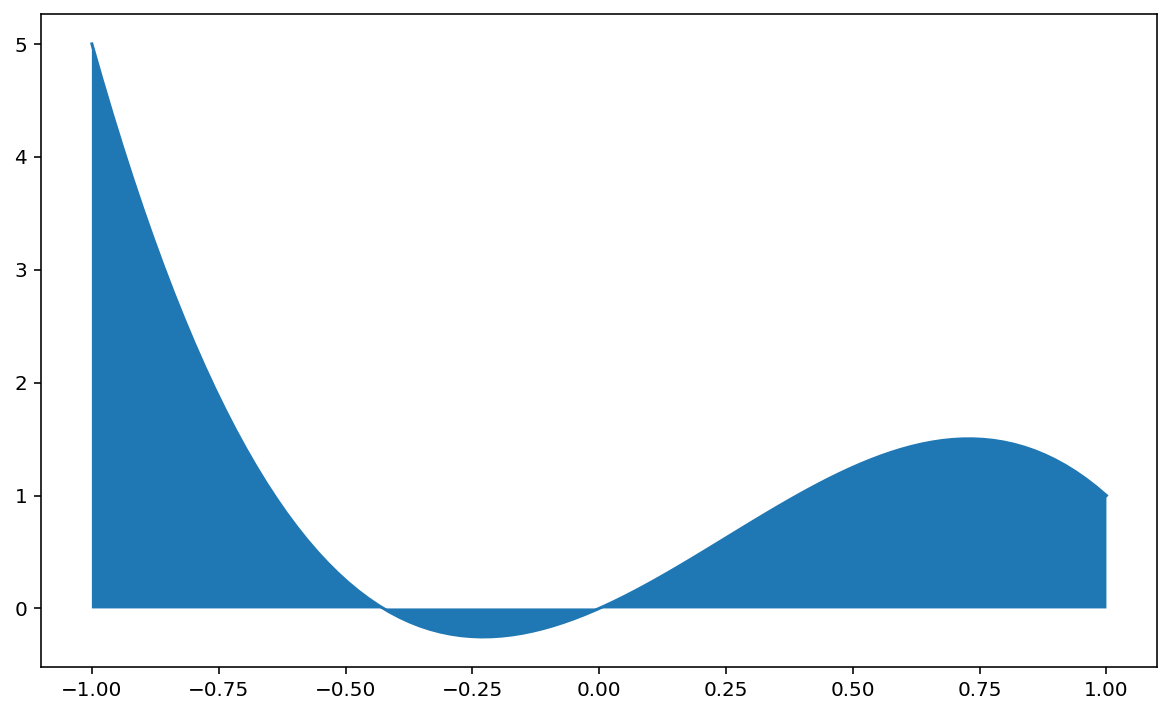

In [3]:
def f(x):
    return -4*x**3 +3*x**2 +2*x

x = np.linspace(-1,1,100)
ax = plt.subplot(1,1,1)
ax.plot(x, f(x))
ax.fill_between(x, 0, f(x));

 we compute integral $\int_a^b f(x)dx$ numerically with $N$ points.

In [4]:
def integrate_f_py(a,b,N):
    s  = 0
    dx = (b - a) / (N-1)
    for i in range(N-1): # we intentionally use the bad way to do this with a loop
        x = a + i*dx
        s += (f(x)+f(x+dx))/2
    return s*dx

In [5]:
%timeit integrate_f_py(-1,1,10**3)
print(integrate_f_py(-1,1,1000))

959 µs ± 7.17 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
2.0000040080120174


In [6]:
%load_ext heat

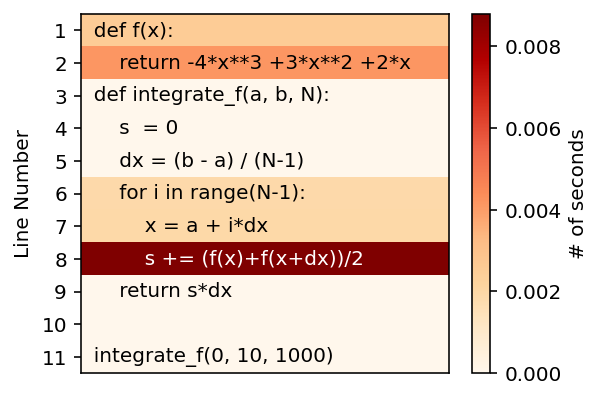

In [7]:
%%heat
def f(x):
    return -4*x**3 +3*x**2 +2*x
def integrate_f(a, b, N):
    s  = 0
    dx = (b - a) / (N-1)
    for i in range(N-1):
        x = a + i*dx
        s += (f(x)+f(x+dx))/2
    return s*dx

integrate_f(0, 10, 1000)

- Pure C function


In [8]:
%%file integral_f_c.c

#include <stdlib.h>
#include <stdio.h>
#include <time.h>

#define NB_RUNS 1000

double f(double x) {
    return -4*x*x*x +3*x*x +2*x;
}

double integrate_f_c(double a, double b, int N) {
    double s  = 0;
    double dx = (b - a) / (N-1);
    for(int i=0; i<N-1; ++i){
        double x = a + i*dx;
        s += (f(x)+f(x+dx))/2.0;
    }
    return s*dx;
}

int main(int argc, char **argv)
{
  
  double a =  atof(argv[1]);
  double b =  atof(argv[2]);
  int N    =  atoi(argv[3]);
  double  res = 0;

  clock_t begin = clock();

  for (int i=0; i<NB_RUNS; ++i)
      res += integrate_f_c( a, b, N );
    
  clock_t end = clock();
     
  fprintf( stdout, "integral_f(%3.1f, %3.1f, %d) = %f \n", a, b, N, res / NB_RUNS );
  fprintf( stdout, "time = %e ms \n",  (double)(end - begin) / CLOCKS_PER_SEC );

  return 0;
}

Writing integral_f_c.c


In [9]:
!gcc -O3 integral_f_c.c; ./a.out -1 1 1000

integral_f(-1.0, 1.0, 1000) = 2.000004 
time = 5.529000e-03 ms 


## Cython compilation: Generating C code

Load Cython in jupyter notebook.

In [10]:
%load_ext Cython

### C Variable and Type definitions

In general, use `cdef` to declare C variables. 
The command :
```sh
$ cython -a mycode.pyx
```
outputs an html file. It shows what parts of your code are C, which parts are Python, and where C-Python conversion occurs.

In [11]:
%%cython -a
cdef int i, j = 2, k = 3      # assigning values at declaration
i = 1                         # assigning values afterwards
# avoid Python-C conversion! It's expensive:
a = 5
i = a
# same with C-Python conversion:
b = j
print("a = %d" % a)
print("i = %d" % i)
print("b = %d" % b)

a = 5
i = 5
b = 2


### Another Python vs. Cython coloring guide

In [12]:
%%cython -a
cdef int m, n
cdef double cy_total = 0.0
for m in range(10):
    n = 2*m
    cy_total += n
a, b = 0, 0
py_total = 0.0
for a in range(10):
    b = 2*a
    py_total += b
print(cy_total, py_total)

90.0 90.0


In [13]:
%%cython -a
cdef struct Grail:
    int age
    float volume
cdef union Food:
    char *spam
    float *eggs
cdef enum CheeseType:
    cheddar, edam,
    camembert
cdef enum CheeseState:
    hard = 1
    soft = 2
    runny = 3
cdef Grail holy
holy.age    = 500
holy.volume = 10.0
print (holy.age, holy.volume)

500 10.0


## Cython Functions

Use **cdef** to define a Cython function.   
 - Cython function can accept either (inclusive) Python and C values as well as return either Python or C values,
 - *Within a Cython module* Python and Cython functions can call each other freely. However, only **Python** functions can be called from outside the module by Python code. (i.e. importing/exporting a Cython module into some Python code)

**cpdef** define a Cython function with a simple Python wrapper. However, when called from Cython the Cython / C code is called directly, bypassing the Python wrapper.  

Writing pure code in Cython gives a small speed boost. Note that none of the code below is Cython-specific. Just add `.pyx` instead of `.py` extension.

In [14]:
%%file cython_f_example.pyx
def f(x):
    return -4*x**3 +3*x**2 +2*x
def integrate_f(a, b, N):
    s  = 0
    dx = (b - a) / (N-1)
    for i in range(N-1):
        x = a + i*dx
        s += (f(x)+f(x+dx))/2
    return s*dx

Writing cython_f_example.pyx


## Cython Compilation

- The .pyx source file is compiled by Cython to a .c file.
- The .c source file contains the code of a Python extension module.
- The .c file is compiled by a C compiler to a .so (shared object library) file which can be imported directly into a Python session.

### Build with CMake
```cmake
project(cython_f_example CXX)
include(UseCython)  # Load Cython functions
# Set C++ output
set_source_file_properties(cython_f_example.pyx PROPERTIES CYTHON_IS_CXX TRUE )
# Build the extension module
cython_add_module( modname cython_f_example.pyx cython_f_example.cpp )
```

### C/C++ generation with cython application
```sh
cython -3 cython_f_example.pyx   # create the C file for Python 3
cython -3 --cplus cython_f_example.pyx  # create the C++ file for Python 3
```


### build with a C/C++ compiler
To build use the Makefile:
```make
CC=gcc
CFLAGS=`python-config --cflags` 
LDFLAGS=`python-config --ldflags`
cython_f_example:
	 ${CC} -c $@.c ${CFLAGS}
	 ${CC} $@.o -o $@.so -shared ${LDFLAGS}
```
Import the module in Python session
```python
import cython_f_example
```



## pyximport

import Cython .pyx files as if they were .py files:

In [15]:
import pyximport
pyximport.install()
import cython_f_example
%timeit cython_f_example.integrate_f(-1,1,10**3)
print(cython_f_example.integrate_f(-1,1,1000))

769 µs ± 6.02 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
2.0000040080120174


## Building a Cython module using distutils

Create the setup.py script:

In [16]:
%%file setup.py
from distutils.core import setup
from Cython.Build import cythonize

setup(
  name = 'Cython Example Integrate f Function',
  ext_modules = cythonize("cython_f_example.pyx"),
)

Writing setup.py


In [17]:
%run setup.py  build_ext --inplace --quiet

Compiling cython_f_example.pyx because it changed.
[1/1] Cythonizing cython_f_example.pyx


running build_ext


building 'cython_f_example' extension


C compiler: gcc -pthread -B /usr/share/miniconda3/envs/runenv/compiler_compat -Wl,--sysroot=/ -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -fPIC



creating build


creating build/temp.linux-x86_64-3.8


compile options: '-I/usr/share/miniconda3/envs/runenv/include/python3.8 -c'


gcc: cython_f_example.c


gcc -pthread -shared -B /usr/share/miniconda3/envs/runenv/compiler_compat -L/usr/share/miniconda3/envs/runenv/lib -Wl,-rpath=/usr/share/miniconda3/envs/runenv/lib -Wl,--no-as-needed -Wl,--sysroot=/ build/temp.linux-x86_64-3.8/cython_f_example.o -o /home/runner/work/python-notebooks/python-notebooks/notebooks/cython_f_example.cpython-38-x86_64-linux-gnu.so


<Figure size 720x432 with 0 Axes>

In [18]:
from cython_f_example import integrate_f
%timeit integrate_f(-1,1,10**3)
integrate_f(-1,1,10**3)

778 µs ± 8.33 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


2.0000040080120174

## Why is it faster with Cython ?

- Python code is interpreted at every execution to machine code.
- Compiled C code is already in machine code.
- C is a statically-typed language. It gives to the compiler more information which allows it to optimize both computations and memory access.
- To add two variables, Python checks the type before calling the right __add__ function and store it to a value that can be new.
- C just add the variables and return the result.


## Add Cython types 
We coerce Python types to C types when calling the function. Still a "Python function" so callable from the global namespace.

In [19]:
%%cython
def f(x):
    return -4*x**3 +3*x**2 +2*x
def cy_integrate_f(double a, double b, int N):
    cdef int i
    cdef double s, x, dx
    s  = 0
    dx = (b - a) / (N-1)
    for i in range(N-1):
        x = a + i*dx
        s += (f(x)+f(x+dx))/2
    return s*dx

building '_cython_magic_8c0baa0b730cb71c660b134eef8e4b03' extension


C compiler: gcc -pthread -B /usr/share/miniconda3/envs/runenv/compiler_compat -Wl,--sysroot=/ -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -fPIC



compile options: '-I/usr/share/miniconda3/envs/runenv/include/python3.8 -c'


gcc: /home/runner/.cache/ipython/cython/_cython_magic_8c0baa0b730cb71c660b134eef8e4b03.c


gcc -pthread -shared -B /usr/share/miniconda3/envs/runenv/compiler_compat -L/usr/share/miniconda3/envs/runenv/lib -Wl,-rpath=/usr/share/miniconda3/envs/runenv/lib -Wl,--no-as-needed -Wl,--sysroot=/ /home/runner/.cache/ipython/cython/home/runner/.cache/ipython/cython/_cython_magic_8c0baa0b730cb71c660b134eef8e4b03.o -o /home/runner/.cache/ipython/cython/_cython_magic_8c0baa0b730cb71c660b134eef8e4b03.cpython-38-x86_64-linux-gnu.so


* typing the iterator variable i with C semantics, tells Cython to compile the for-loop to pure C code.
* typing a, s and dx is important as they are involved in arithmetic within the for-loop

* Cython type declarations can make the source code less readable
* Do not use them without good reason, i.e. only in performance critical sections.

In [20]:
%timeit cy_integrate_f(-1,1,10**3)
print(cy_integrate_f(-1,1,1000))

687 µs ± 3.44 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
2.0000040080120174


Finally, we integrate a Cython function instead of a Python function. 
This eliminates the Python-C conversion at the function call as seen 
above thus giving a pure Cython/C algorithm.

The primary downside is not being allowed to call
the function `cy_f`, from Python unless `cpdef` is used. 

In [21]:
%%cython
cdef double cy_f(double x):
    return -4*x**3 +3*x**2 +2*x
def cycy_integrate_f(double a, double b, int N):
    cdef int i
    cdef double s, x, dx
    s  = 0
    dx = (b - a) / (N-1)
    for i in range(N-1):
        x = a + i*dx
        s += (cy_f(x)+cy_f(x+dx))/2
    return s*dx

building '_cython_magic_c253bb1961eda445c34ddc2d7b4ab8bc' extension


C compiler: gcc -pthread -B /usr/share/miniconda3/envs/runenv/compiler_compat -Wl,--sysroot=/ -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -fPIC



compile options: '-I/usr/share/miniconda3/envs/runenv/include/python3.8 -c'


gcc: /home/runner/.cache/ipython/cython/_cython_magic_c253bb1961eda445c34ddc2d7b4ab8bc.c


gcc -pthread -shared -B /usr/share/miniconda3/envs/runenv/compiler_compat -L/usr/share/miniconda3/envs/runenv/lib -Wl,-rpath=/usr/share/miniconda3/envs/runenv/lib -Wl,--no-as-needed -Wl,--sysroot=/ /home/runner/.cache/ipython/cython/home/runner/.cache/ipython/cython/_cython_magic_c253bb1961eda445c34ddc2d7b4ab8bc.o -o /home/runner/.cache/ipython/cython/_cython_magic_c253bb1961eda445c34ddc2d7b4ab8bc.cpython-38-x86_64-linux-gnu.so


In [22]:
%timeit cycy_integrate_f(-1,1,10**3)
print(cycy_integrate_f(-1,1,1000))

172 µs ± 704 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
2.0000040080120174


## Exercise : Cythonize the trivial exponential function.

In [23]:
%%cython -a
def exp_python(x,terms=50):
    sum = 0.
    power = 1.
    fact = 1.
    for i in range(terms):
        sum += power/fact
        power *= x
        fact *= i+1
    return sum

building '_cython_magic_a96a095f6c3175b142027432bac51f88' extension


C compiler: gcc -pthread -B /usr/share/miniconda3/envs/runenv/compiler_compat -Wl,--sysroot=/ -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -fPIC



compile options: '-I/usr/share/miniconda3/envs/runenv/include/python3.8 -c'


gcc: /home/runner/.cache/ipython/cython/_cython_magic_a96a095f6c3175b142027432bac51f88.c


gcc -pthread -shared -B /usr/share/miniconda3/envs/runenv/compiler_compat -L/usr/share/miniconda3/envs/runenv/lib -Wl,-rpath=/usr/share/miniconda3/envs/runenv/lib -Wl,--no-as-needed -Wl,--sysroot=/ /home/runner/.cache/ipython/cython/home/runner/.cache/ipython/cython/_cython_magic_a96a095f6c3175b142027432bac51f88.o -o /home/runner/.cache/ipython/cython/_cython_magic_a96a095f6c3175b142027432bac51f88.cpython-38-x86_64-linux-gnu.so


In [24]:
%timeit exp_python(1.,50)

4.45 µs ± 71 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [25]:
%%cython

# %load solutions/cython/exponential.pyx
#cython: profile=False
#cython: cdivision=True
def exp_cython(double x, int terms = 50):
   cdef double sum
   cdef double power
   cdef double fact
   cdef int i
   sum = 0.
   power = 1.
   fact = 1.
   for i in range(terms):
      sum += power/fact
      power *= x
      fact *= i+1
   return sum


building '_cython_magic_f09447b346fe20b620ea715f5b8935ac' extension


C compiler: gcc -pthread -B /usr/share/miniconda3/envs/runenv/compiler_compat -Wl,--sysroot=/ -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -fPIC



compile options: '-I/usr/share/miniconda3/envs/runenv/include/python3.8 -c'


gcc: /home/runner/.cache/ipython/cython/_cython_magic_f09447b346fe20b620ea715f5b8935ac.c


gcc -pthread -shared -B /usr/share/miniconda3/envs/runenv/compiler_compat -L/usr/share/miniconda3/envs/runenv/lib -Wl,-rpath=/usr/share/miniconda3/envs/runenv/lib -Wl,--no-as-needed -Wl,--sysroot=/ /home/runner/.cache/ipython/cython/home/runner/.cache/ipython/cython/_cython_magic_f09447b346fe20b620ea715f5b8935ac.o -o /home/runner/.cache/ipython/cython/_cython_magic_f09447b346fe20b620ea715f5b8935ac.cpython-38-x86_64-linux-gnu.so


In [26]:
%timeit exp_cython(1.,50)

165 ns ± 1.68 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


## Cython and Numpy

The Numpy library contains many fast numerics routines. Their speed comes 
from manipulating the low-level C-arrays that the numpy.array object wraps 
rather than computing over slow Python lists. Using Cython one can access 
those low-level arrays and implement their own fast algorithms while allowing 
the easy interaction afforded by Python + Numpy.

The examples below are various implementations of the naive matrix multiplication 
algorithm. We will start with a pure Python implementation and then incrementally 
add structures that allow Cython to exploit the low-level speed of the numpy.array 
object.

### Pure Python implementation compiled in Cython without specific optimizations.

In [27]:
%%cython
def matmul1(A, B, out=None):
    assert A.shape[1] == B.shape[0]
    for i in range(A.shape[0]):
        for j in range(B.shape[1]):
            s = 0
            for k in range(A.shape[1]):
                s += A[i,k] * B[k,j]
            out[i,j] = s
    return out

building '_cython_magic_899b76c7c47e2932ff2e677e49192f5a' extension


C compiler: gcc -pthread -B /usr/share/miniconda3/envs/runenv/compiler_compat -Wl,--sysroot=/ -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -fPIC



compile options: '-I/usr/share/miniconda3/envs/runenv/include/python3.8 -c'


gcc: /home/runner/.cache/ipython/cython/_cython_magic_899b76c7c47e2932ff2e677e49192f5a.c


gcc -pthread -shared -B /usr/share/miniconda3/envs/runenv/compiler_compat -L/usr/share/miniconda3/envs/runenv/lib -Wl,-rpath=/usr/share/miniconda3/envs/runenv/lib -Wl,--no-as-needed -Wl,--sysroot=/ /home/runner/.cache/ipython/cython/home/runner/.cache/ipython/cython/_cython_magic_899b76c7c47e2932ff2e677e49192f5a.o -o /home/runner/.cache/ipython/cython/_cython_magic_899b76c7c47e2932ff2e677e49192f5a.cpython-38-x86_64-linux-gnu.so


### Import numpy as a Cython module

We now take advantage of the ability to access the underlying C arrays in the `numpy.array` object from Cython, thanks to a special `numpy.pxd` file included with Cython. (The Cython developers worked closely with Numpy developers to make this optimal.) 

To begin with, we have to `cimport` numpy: that is, import numpy as a **Cython** module rather than a **Python** module. To do so, simply type:

```python
cimport numpy as np
```
Another important thing to note is the type of Numpy indexers. There is a special Numpy variable type used for `numpy.array` indices called `Py_ssize_t`. To take full advantage of the speedups that Cython can provide we should make sure to type the variables used for indexing as such.


In [28]:
%%cython
import numpy as np
cimport numpy as np
ctypedef np.float64_t dtype_t      # shorthand type. easy to change
def matmul2(np.ndarray[dtype_t, ndim=2] A,
            np.ndarray[dtype_t, ndim=2] B,
            np.ndarray[dtype_t, ndim=2] out=None):
    cdef Py_ssize_t i, j, k
    cdef dtype_t s
    assert A.shape[1] == B.shape[0]
    for i in range(A.shape[0]):
        for j in range(B.shape[1]):
            s = 0
            for k in range(A.shape[1]):
                s += A[i,k] * B[k,j]
            out[i,j] = s
    return out

building '_cython_magic_44357700cb4ec61887ddbee898be64d7' extension


C compiler: gcc -pthread -B /usr/share/miniconda3/envs/runenv/compiler_compat -Wl,--sysroot=/ -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -fPIC



compile options: '-I/usr/share/miniconda3/envs/runenv/lib/python3.8/site-packages/numpy/core/include -I/usr/share/miniconda3/envs/runenv/include/python3.8 -c'


gcc: /home/runner/.cache/ipython/cython/_cython_magic_44357700cb4ec61887ddbee898be64d7.c


gcc -pthread -shared -B /usr/share/miniconda3/envs/runenv/compiler_compat -L/usr/share/miniconda3/envs/runenv/lib -Wl,-rpath=/usr/share/miniconda3/envs/runenv/lib -Wl,--no-as-needed -Wl,--sysroot=/ /home/runner/.cache/ipython/cython/home/runner/.cache/ipython/cython/_cython_magic_44357700cb4ec61887ddbee898be64d7.o -o /home/runner/.cache/ipython/cython/_cython_magic_44357700cb4ec61887ddbee898be64d7.cpython-38-x86_64-linux-gnu.so


In [29]:
import numpy as np
from timeit import timeit
A = np.random.random_sample((64,64))
B = np.random.random_sample((64,64))
C = np.zeros((64,64))

In [30]:
%timeit matmul1(A,B,C)

149 ms ± 1.79 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [31]:
%timeit matmul2(A,B,C)

361 µs ± 3.67 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### Tuning indexing
The array lookups are still slowed down by two factors:
  * Bounds checking is performed.
  * Negative indices are checked for and handled correctly. 
  
The code doesn’t use negative indices, and always access to arrays within bounds. We can add a decorator to disable bounds checking:

In [32]:
%%cython
cimport cython                                       # cython tools
import numpy as np
cimport numpy as np
ctypedef np.float64_t dtype_t
@cython.boundscheck(False) # turn off bounds-checking for entire function
@cython.wraparound(False)  # turn off negative index wrapping for entire function
def matmul3(np.ndarray[dtype_t, ndim=2] A,
            np.ndarray[dtype_t, ndim=2] B,
            np.ndarray[dtype_t, ndim=2] out=None):
    cdef Py_ssize_t i, j, k
    cdef dtype_t s
    assert A.shape[1] == B.shape[0]
    for i in range(A.shape[0]):
        for j in range(B.shape[1]):
            s = 0
            for k in range(A.shape[1]):
                s += A[i,k] * B[k,j]
            out[i,j] = s
    return out

building '_cython_magic_75874d7a10a3fb62ace5ee487efe1f5a' extension


C compiler: gcc -pthread -B /usr/share/miniconda3/envs/runenv/compiler_compat -Wl,--sysroot=/ -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -fPIC



compile options: '-I/usr/share/miniconda3/envs/runenv/lib/python3.8/site-packages/numpy/core/include -I/usr/share/miniconda3/envs/runenv/lib/python3.8/site-packages/numpy/core/include -I/usr/share/miniconda3/envs/runenv/include/python3.8 -c'


gcc: /home/runner/.cache/ipython/cython/_cython_magic_75874d7a10a3fb62ace5ee487efe1f5a.c


gcc -pthread -shared -B /usr/share/miniconda3/envs/runenv/compiler_compat -L/usr/share/miniconda3/envs/runenv/lib -Wl,-rpath=/usr/share/miniconda3/envs/runenv/lib -Wl,--no-as-needed -Wl,--sysroot=/ /home/runner/.cache/ipython/cython/home/runner/.cache/ipython/cython/_cython_magic_75874d7a10a3fb62ace5ee487efe1f5a.o -o /home/runner/.cache/ipython/cython/_cython_magic_75874d7a10a3fb62ace5ee487efe1f5a.cpython-38-x86_64-linux-gnu.so


In [33]:
%timeit matmul3(A,B,C)

324 µs ± 8.76 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## Cython Build Options

- boundcheck(True,False) : array bounds checking
- wraparound(True,False) : negative indexing.
- initializedcheck(True,False): checks that a memoryview is initialized 
- nonecheck(True,False) : Check if one argument is  None
- overflowcheck(True,False) : Check if int are too big
- cdivision(True,False) : If False, adjust the remainder and quotient operators C types to match those of Python ints. Could be very effective when it is set to True.
- profile (True / False) : Write hooks for Python profilers into the compiled C code. Default is False.

[Cython Compiler directives](http://docs.cython.org/en/latest/src/reference/compilation.html#compiler-directives)

## Numpy objects with external C program. 

Note that this can actually be slower 
because the C function is not the best implementation of matrix multiplication. Call cblas with same technique is an interesting exercise.

In [34]:
%%file mydgemm.c 
void my_dgemm( int m, int n, int k, 
              double a[m][n], double b[n][k], float c[m][k] )
{
  double ab = 0;
  for( int j = 0 ; j < m ; j++ ) {
    for( int i = 0 ; i < k ; i++ ) {
      for( int l = 0 ; l < n ; l++ ){
        ab += a[j][l] * b[l][i];
      }
      c[j][i] = ab ;
      ab = 0;
    }
  }
}

Writing mydgemm.c


- The `np.ndarray[double, ndim=2, mode="c"]` assures that you get a C-contiguous numpy array of doubles 
- The `&input[0,0]` passed in the address of the beginning of the data array.

In [35]:
from pyximport import install
import os
here = os.getcwd()

In [36]:
%%cython -I {here}
# do not forget to change the file path
cdef extern from "mydgemm.c":
    void my_dgemm (int m, int n, int k, 
                          double *A, double *B, double *C)
cimport cython
import numpy as np
cimport numpy as np
ctypedef np.float64_t dtype_t
@cython.boundscheck(False)
@cython.wraparound(False) 
def matmul4(np.ndarray[dtype_t, ndim=2, mode="c"] A,
            np.ndarray[dtype_t, ndim=2, mode="c"] B,
            np.ndarray[dtype_t, ndim=2, mode="c"] C=None):
    cdef int m = A.shape[0]
    cdef int n = A.shape[1]
    cdef int k = B.shape[1]
    cdef dtype_t s
    
    my_dgemm(m, n, k, &A[0,0], &B[0,0], &C[0,0])
                                                  
    return C

building '_cython_magic_3182af7b83c2474db8f1f7bb74b9f4d7' extension


C compiler: gcc -pthread -B /usr/share/miniconda3/envs/runenv/compiler_compat -Wl,--sysroot=/ -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -fPIC



compile options: '-I/usr/share/miniconda3/envs/runenv/lib/python3.8/site-packages/numpy/core/include -I/usr/share/miniconda3/envs/runenv/lib/python3.8/site-packages/numpy/core/include -I/home/runner/work/python-notebooks/python-notebooks/notebooks -I/usr/share/miniconda3/envs/runenv/lib/python3.8/site-packages/numpy/core/include -I/usr/share/miniconda3/envs/runenv/include/python3.8 -c'


gcc: /home/runner/.cache/ipython/cython/_cython_magic_3182af7b83c2474db8f1f7bb74b9f4d7.c


gcc -pthread -shared -B /usr/share/miniconda3/envs/runenv/compiler_compat -L/usr/share/miniconda3/envs/runenv/lib -Wl,-rpath=/usr/share/miniconda3/envs/runenv/lib -Wl,--no-as-needed -Wl,--sysroot=/ /home/runner/.cache/ipython/cython/home/runner/.cache/ipython/cython/_cython_magic_3182af7b83c2474db8f1f7bb74b9f4d7.o -o /home/runner/.cache/ipython/cython/_cython_magic_3182af7b83c2474db8f1f7bb74b9f4d7.cpython-38-x86_64-linux-gnu.so


In [37]:
%timeit matmul4(A,B,C)

311 µs ± 3.29 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### Exercise : Find prime numbers < 10000

In [38]:
# %load solutions/cython/is_prime0.py

def is_prime0(n):
    if n < 4: return True
    if n % 2 == 0 : return False
    k = 3
    while k*k <= n:
        if n % k == 0: return False
        k += 2
    return True

In [39]:
[ p for p in range(20) if is_prime0(p)]

[0, 1, 2, 3, 5, 7, 11, 13, 17, 19]

In [40]:
L = list(range(10000))
%timeit [ p for p in L if is_prime0(p)]

8.55 ms ± 72.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [41]:
%%cython
def is_prime1(n):
    if n < 4: return True
    if n % 2 == 0 : return False
    k = 3
    while k*k <= n:
        if n % k == 0: return False
        k += 2
    return True

building '_cython_magic_f81b23461181c5d78ab3700de598d3b5' extension


C compiler: gcc -pthread -B /usr/share/miniconda3/envs/runenv/compiler_compat -Wl,--sysroot=/ -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -fPIC



compile options: '-I/usr/share/miniconda3/envs/runenv/lib/python3.8/site-packages/numpy/core/include -I/usr/share/miniconda3/envs/runenv/lib/python3.8/site-packages/numpy/core/include -I/usr/share/miniconda3/envs/runenv/include/python3.8 -c'


gcc: /home/runner/.cache/ipython/cython/_cython_magic_f81b23461181c5d78ab3700de598d3b5.c


gcc -pthread -shared -B /usr/share/miniconda3/envs/runenv/compiler_compat -L/usr/share/miniconda3/envs/runenv/lib -Wl,-rpath=/usr/share/miniconda3/envs/runenv/lib -Wl,--no-as-needed -Wl,--sysroot=/ /home/runner/.cache/ipython/cython/home/runner/.cache/ipython/cython/_cython_magic_f81b23461181c5d78ab3700de598d3b5.o -o /home/runner/.cache/ipython/cython/_cython_magic_f81b23461181c5d78ab3700de598d3b5.cpython-38-x86_64-linux-gnu.so


In [42]:
[ p for p in range(20) if is_prime1(p)]

[0, 1, 2, 3, 5, 7, 11, 13, 17, 19]

In [43]:
%timeit [p  for p in L if is_prime1(p)]

4.44 ms ± 77.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Add Cython types without modifying the Python Code

In [44]:
%%cython
import cython
@cython.locals(n=int, k=int)
def is_prime2(n):
    if n < 4: return True
    if n % 2 == 0 : return False
    k = 3
    while k*k <= n:
        if n % k == 0: return False
        k += 2
    return True

building '_cython_magic_745b858a4456e55af5f92e69b9968cd3' extension


C compiler: gcc -pthread -B /usr/share/miniconda3/envs/runenv/compiler_compat -Wl,--sysroot=/ -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -fPIC



compile options: '-I/usr/share/miniconda3/envs/runenv/lib/python3.8/site-packages/numpy/core/include -I/usr/share/miniconda3/envs/runenv/lib/python3.8/site-packages/numpy/core/include -I/usr/share/miniconda3/envs/runenv/include/python3.8 -c'


gcc: /home/runner/.cache/ipython/cython/_cython_magic_745b858a4456e55af5f92e69b9968cd3.c


gcc -pthread -shared -B /usr/share/miniconda3/envs/runenv/compiler_compat -L/usr/share/miniconda3/envs/runenv/lib -Wl,-rpath=/usr/share/miniconda3/envs/runenv/lib -Wl,--no-as-needed -Wl,--sysroot=/ /home/runner/.cache/ipython/cython/home/runner/.cache/ipython/cython/_cython_magic_745b858a4456e55af5f92e69b9968cd3.o -o /home/runner/.cache/ipython/cython/_cython_magic_745b858a4456e55af5f92e69b9968cd3.cpython-38-x86_64-linux-gnu.so


In [45]:
[ p for p in range(20) if is_prime2(p)]

[0, 1, 2, 3, 5, 7, 11, 13, 17, 19]

In [46]:
%timeit [p for p in L if is_prime2(p) ]

672 µs ± 1.16 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### Cython function 

In [47]:
%%cython
import cython
cdef bint is_prime3(int n):
    if n < 4: return True
    if n % 2 == 0: return False
    cdef int k = 3
    while k*k <= n:
        if n % k == 0: return False
        k += 2
    return True
def prime_list(L):
    return [p for p in L if is_prime3(p)]

building '_cython_magic_666b225df8666611ff2af72a85a03e9d' extension


C compiler: gcc -pthread -B /usr/share/miniconda3/envs/runenv/compiler_compat -Wl,--sysroot=/ -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -fPIC



compile options: '-I/usr/share/miniconda3/envs/runenv/lib/python3.8/site-packages/numpy/core/include -I/usr/share/miniconda3/envs/runenv/lib/python3.8/site-packages/numpy/core/include -I/usr/share/miniconda3/envs/runenv/include/python3.8 -c'


gcc: /home/runner/.cache/ipython/cython/_cython_magic_666b225df8666611ff2af72a85a03e9d.c


gcc -pthread -shared -B /usr/share/miniconda3/envs/runenv/compiler_compat -L/usr/share/miniconda3/envs/runenv/lib -Wl,-rpath=/usr/share/miniconda3/envs/runenv/lib -Wl,--no-as-needed -Wl,--sysroot=/ /home/runner/.cache/ipython/cython/home/runner/.cache/ipython/cython/_cython_magic_666b225df8666611ff2af72a85a03e9d.o -o /home/runner/.cache/ipython/cython/_cython_magic_666b225df8666611ff2af72a85a03e9d.cpython-38-x86_64-linux-gnu.so


In [48]:
prime_list(list(range(20)))

[0, 1, 2, 3, 5, 7, 11, 13, 17, 19]

In [49]:
%timeit prime_list(L)

350 µs ± 3.36 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [50]:
%%cython
import cython
from numpy cimport ndarray
import numpy

cdef bint is_prime3(int n):
    if n < 4: return True
    if n % 2 == 0: return False
    cdef int k = 3
    while k*k <= n:
        if n % k == 0: return False
        k += 2
    return True

def prime_array(ndarray[int, ndim=1] L):
    cdef ndarray[int, ndim=1] res = ndarray(shape=(L.shape[0]),dtype=numpy.int32)
    cdef int i
    for i in range(L.shape[0]):
        res[i] = is_prime3(L[i])
    return L[res==1]

building '_cython_magic_2a5b09b5e9c574f8e7fa68917eb3edc0' extension


C compiler: gcc -pthread -B /usr/share/miniconda3/envs/runenv/compiler_compat -Wl,--sysroot=/ -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -fPIC



compile options: '-I/usr/share/miniconda3/envs/runenv/lib/python3.8/site-packages/numpy/core/include -I/usr/share/miniconda3/envs/runenv/lib/python3.8/site-packages/numpy/core/include -I/usr/share/miniconda3/envs/runenv/lib/python3.8/site-packages/numpy/core/include -I/usr/share/miniconda3/envs/runenv/include/python3.8 -c'


gcc: /home/runner/.cache/ipython/cython/_cython_magic_2a5b09b5e9c574f8e7fa68917eb3edc0.c


gcc -pthread -shared -B /usr/share/miniconda3/envs/runenv/compiler_compat -L/usr/share/miniconda3/envs/runenv/lib -Wl,-rpath=/usr/share/miniconda3/envs/runenv/lib -Wl,--no-as-needed -Wl,--sysroot=/ /home/runner/.cache/ipython/cython/home/runner/.cache/ipython/cython/_cython_magic_2a5b09b5e9c574f8e7fa68917eb3edc0.o -o /home/runner/.cache/ipython/cython/_cython_magic_2a5b09b5e9c574f8e7fa68917eb3edc0.cpython-38-x86_64-linux-gnu.so


In [51]:
import numpy as np
prime_array(np.arange(20,dtype=np.int32))

array([ 0,  1,  2,  3,  5,  7, 11, 13, 17, 19], dtype=int32)

In [52]:
npL = numpy.array(L,dtype=np.int32)
%timeit prime_array(npL)

358 µs ± 4.06 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## Using Parallelism

* Cython supports native parallelism via OpenMP
* by default, Python’s Global Interpreter Lock (GIL) prevents that several threads use the Python interpreter simultaneously
* to use this kind of parallelism, the GIL must be released

If you have a default compiler with openmp support you can use
this magic command in your notebook.
```cython
%%cython --compile-args=-fopenmp --link-args=-fopenmp
```

In [53]:
%%file cython_omp.pyx
import cython
from cython.parallel cimport parallel, prange  # import parallel functions
import numpy as np
from numpy cimport ndarray

cdef bint is_prime4(int n) nogil:      #release the gil 
    if n < 4: return True
    if n % 2 == 0: return False
    cdef int k = 3
    while k*k <= n:
        if n % k == 0: return False
        k += 2
    return True

@cython.boundscheck(False)
def prime_array_omp(ndarray[int, ndim=1] L):
    cdef ndarray[int, ndim=1] res = ndarray(shape=(L.shape[0]),dtype=np.int32)
    cdef Py_ssize_t i
    with nogil, parallel(num_threads=4):
        for i in prange(L.shape[0]):     #Parallel loop
            res[i] = is_prime4(L[i])
    return L[res==1]

Writing cython_omp.pyx


To use the OpenMP support, you need to enable OpenMP. For gcc this can be done as follows in a setup.py:

In [54]:
%%file setup.py
from distutils.core import setup
from distutils.extension import Extension
from Cython.Build import cythonize
import os, sys
import numpy

if sys.platform == "darwin": # for omp, use gcc installed with brew
    os.environ["CC"]="gcc-10"
    os.environ["CXX"]="g++-10"

ext_modules = [
    Extension(
        "cython_omp",
        ["cython_omp.pyx"],
        extra_compile_args=['-fopenmp'],
        extra_link_args=['-fopenmp'],
        include_dirs=[numpy.get_include()]
    )
]

setup(
    name='Cython OpenMP Example',
    ext_modules=cythonize(ext_modules),
)
# python setup.py build_ext --inplace

Overwriting setup.py


In [55]:
%run setup.py build_ext --inplace --quiet

Compiling cython_omp.pyx because it changed.
[1/1] Cythonizing cython_omp.pyx


running build_ext


building 'cython_omp' extension


C compiler: gcc -pthread -B /usr/share/miniconda3/envs/runenv/compiler_compat -Wl,--sysroot=/ -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -fPIC



compile options: '-I/usr/share/miniconda3/envs/runenv/lib/python3.8/site-packages/numpy/core/include -I/usr/share/miniconda3/envs/runenv/include/python3.8 -c'
extra options: '-fopenmp'


gcc: cython_omp.c


gcc -pthread -shared -B /usr/share/miniconda3/envs/runenv/compiler_compat -L/usr/share/miniconda3/envs/runenv/lib -Wl,-rpath=/usr/share/miniconda3/envs/runenv/lib -Wl,--no-as-needed -Wl,--sysroot=/ build/temp.linux-x86_64-3.8/cython_omp.o -o /home/runner/work/python-notebooks/python-notebooks/notebooks/cython_omp.cpython-38-x86_64-linux-gnu.so -fopenmp


In [56]:
from cython_omp import prime_array_omp

In [57]:
prime_array_omp(np.arange(20,dtype=np.int32))

array([ 0,  1,  2,  3,  5,  7, 11, 13, 17, 19], dtype=int32)

In [58]:
%timeit prime_array_omp(npL)

279 µs ± 8.53 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## References
* [Cython documentation](http://docs.cython.org/en/latest/)
* [An Interactive Introduction to Cython by Chris Swierczewski](http://www.cswiercz.info)
* [Introduction To Python by Michael Kraus](http://michael-kraus.org/introduction-to-python.html)
* [Cython by Xavier Juvigny 🇫🇷](http://calcul.math.cnrs.fr/IMG/pdf/cythontalk.pdf)
* [Cython: C-Extensions for Python, Wiki](https://github.com/cython/cython/wiki)
* Kurt W. Smith
    - [Cython A Guide for Python Programmers](http://shop.oreilly.com/product/0636920033431.do)
    - [Cython: Blend the Best of Python and C++ | SciPy 2015 Tutorial | Kurt Smith
](https://youtu.be/gMvkiQ-gOW8)
    - [Cython: Speed up Python and NumPy, Pythonize C, C++, and Fortran, SciPy2013 Kurt W. Smith](https://youtu.be/JKCjsRDffXo)
    - [SciPy 2017 - Cython by ](https://youtu.be/FepqwPI6U80)
    - [Cython Book examples](https://github.com/cythonbook)
    
* [Parallel computing in Cython/threads - Neal Hughes](http://nealhughes.net/parallelcomp2/)